In [237]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "whitegrid")

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import xgboost as xgb
import mord as m
import shap 

In [206]:
df = pd.read_csv("C:\\Users\\mckmo\\Downloads\\wine+quality\\winequality-red.csv", sep=";")
print("Shape:", df.shape)
print(df.isnull().sum())
print(df.describe())
df.head() 


Shape: (1599, 12)
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chloride

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


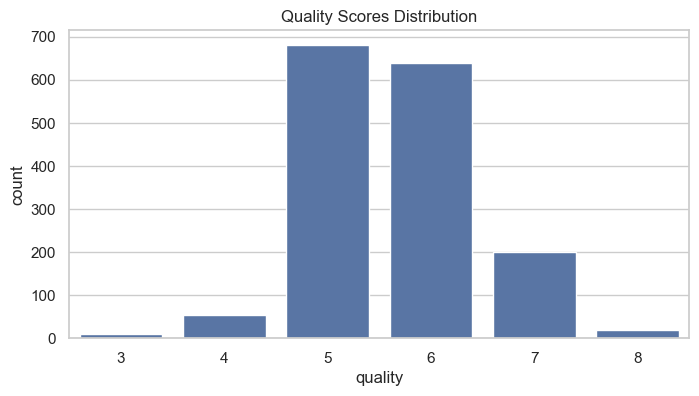

In [207]:
plt.figure(figsize = (8,4))
sns.countplot(x = "quality", data = df)
plt.title("Quality Scores Distribution")
plt.show()

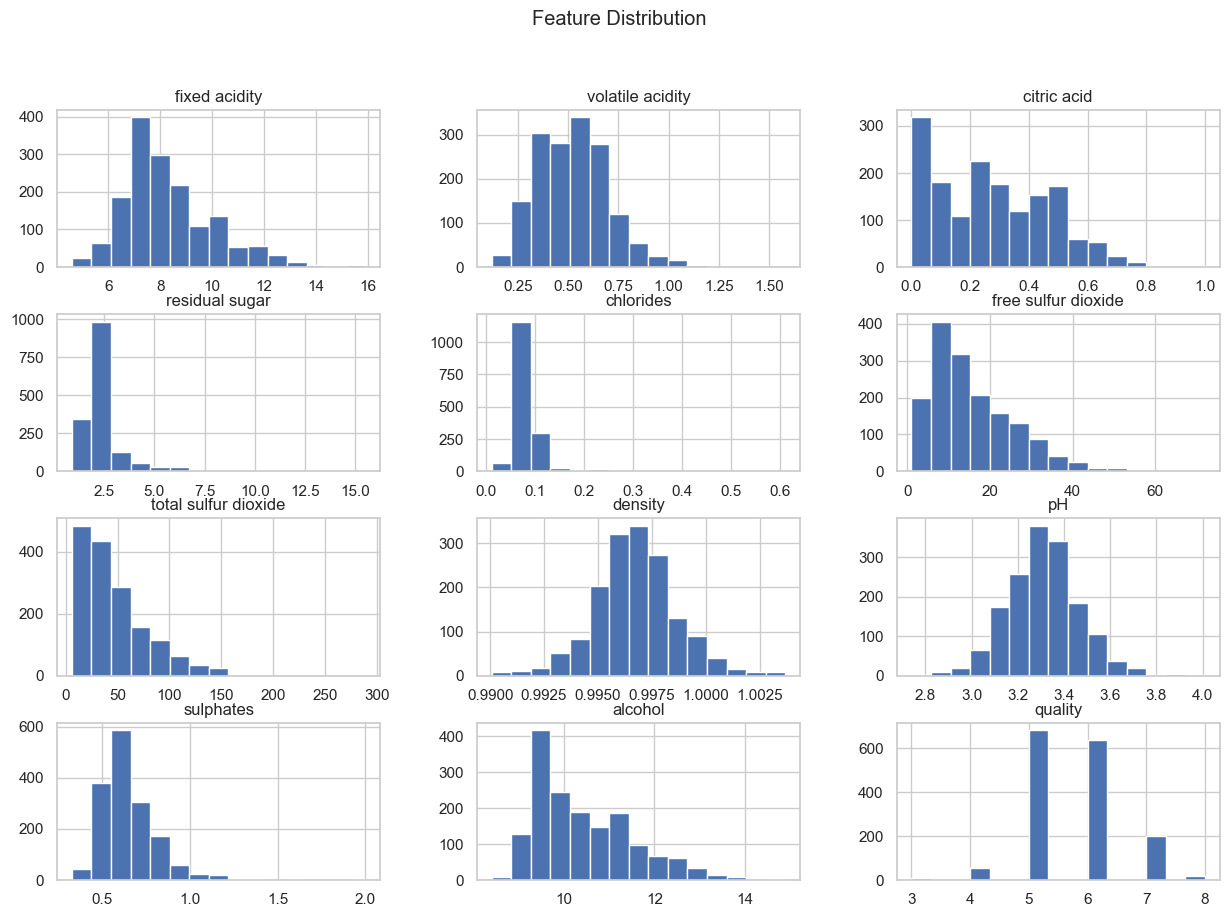

In [208]:
# Distribution Histogram Distributions
df.hist(bins = 15, figsize = (15,10), layout = (4,3))
plt.suptitle("Feature Distribution")
plt.show()

Careful with outliers in: residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, sulphates

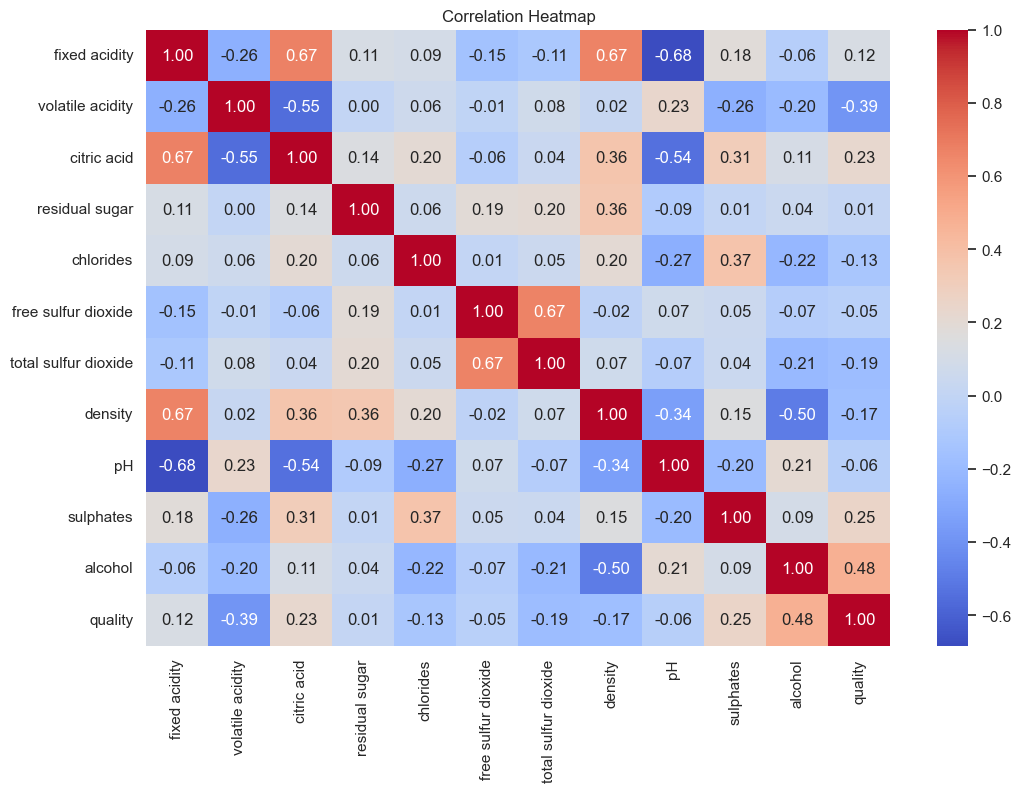

In [209]:
# Correlation Heatmap
plt.figure(figsize = (12,8))
sns.heatmap(df.corr(), annot = True , fmt = ".2f", cmap="coolwarm")
# prints numbers, .2f = 2 decimal places
plt.title("Correlation Heatmap")
plt.show()

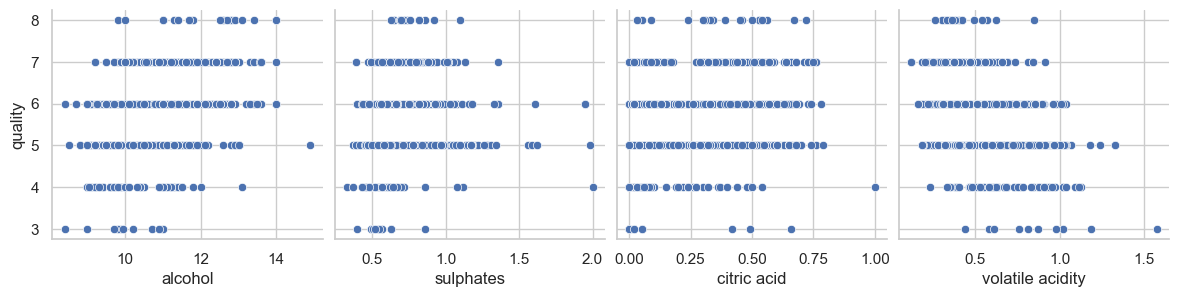

In [210]:
# Pairwise Plots
top_features = ["alcohol","sulphates", "citric acid", "volatile acidity"]
sns.pairplot(df, x_vars = top_features, y_vars = "quality", kind = "scatter", height = 3)
plt.show()

Prepare data for modeling

In [238]:

X = df.drop("quality", axis = 1)
y = df["quality"]


# Adding a constant (intercept) for statsmodels VIF calc
X_vif = X.copy()
X_vif['intercept'] = 1 

# Calc VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
vif_results = vif_data[vif_data["Feature"] != "intercept"].sort_values(by="VIF", ascending=False)

print("VIF Results (Before Split):")
print(vif_results)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify = y)

skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=123 )

VIF Results (Before Split):
                 Feature       VIF
0          fixed acidity  7.767512
7                density  6.343760
8                     pH  3.329732
2            citric acid  3.128022
10               alcohol  3.031160
6   total sulfur dioxide  2.186813
5    free sulfur dioxide  1.963019
1       volatile acidity  1.789390
3         residual sugar  1.702588
4              chlorides  1.481932
9              sulphates  1.429434


Linear Regression

In [212]:

lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
predict = lr_pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)

print(f"Linear Regression Results:\nRMSE: {rmse:.3f}\nMAE: {mae:.3f}\nR-squared: {r2:.3f}")

Linear Regression Results:
RMSE: 0.660
MAE: 0.534
R-squared: 0.344


In [ ]:
lr_cv_scores = cross_val_score(lr_pipeline, X, y, cv=skf, scoring = "r2")
print("Linear Regression CV R-squared Scores:", np.round(lr_cv_scores, 3))
print("Mean R-squared:", np.round(np.mean(lr_cv_scores), 3))
print("StDev R-squared:", np.round(np.std(lr_cv_scores), 3))

Linear Regression CV R-squared Scores: [0.344 0.357 0.348 0.329 0.352]
Mean R-squared: 0.346
StDev R-squared: 0.01


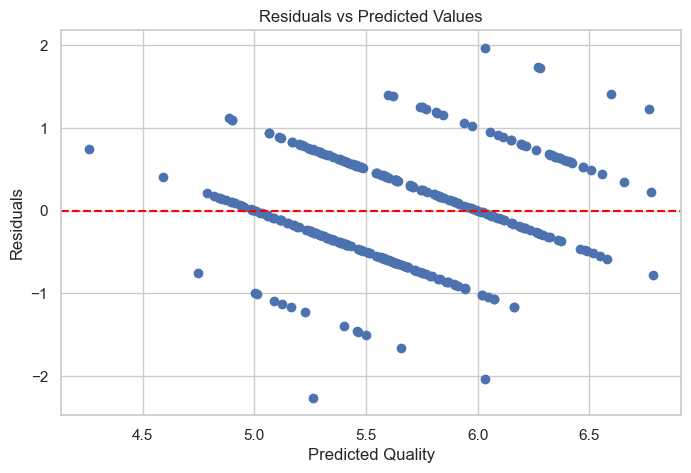

In [214]:
residuals = y_test - predict

plt.figure(figsize = (8,5))
plt.scatter(predict, residuals)
plt.axhline(0, color = 'red', linestyle = "--")
plt.xlabel("Predicted Quality")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

Clear bias and heteroscedasticity ^

Ordinal Regression 

In [215]:
ord_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", m.LogisticAT(alpha=1.0))
])

ord_pipeline.fit(X_train, y_train)
ord_preds = ord_pipeline.predict(X_test)

acc_ord = accuracy_score(y_test, ord_preds)
mae_ord = mean_absolute_error(y_test, ord_preds)

print("Ordinal Regression Results")
print(f"Accuracy: {acc_ord:.3f}\nMAE: {mae_ord:.3f}")

Ordinal Regression Results
Accuracy: 0.512
MAE: 0.506


In [ ]:
ord_cv_scores = cross_val_score(ord_pipeline, X, y, cv=skf, scoring = "neg_mean_absolute_error")
print("Ordinal Regression CV MAE:", np.round(-ord_cv_scores, 3))
print("Mean MAE:", np.round(-np.mean(ord_cv_scores), 3))
print("StDev MAE:", np.round(np.std(-ord_cv_scores), 3))
# MAE better captures ordered distance btwn predicted categories

Ordinal Regression CV MAE: [0.506 0.403 0.444 0.441 0.42 ]
Mean MAE: 0.443
StDev MAE: 0.035


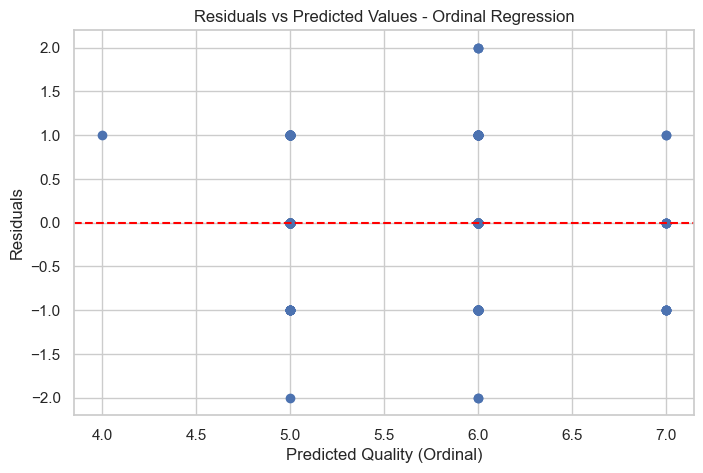

In [217]:
# Ordinal Regression Residuals
ord_residual = y_test - ord_preds
plt.figure(figsize=(8,5))
plt.scatter(ord_preds, ord_residual)
plt.axhline(0, color = "red", linestyle="--")
plt.xlabel("Predicted Quality (Ordinal)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values - Ordinal Regression")
plt.show()

In [218]:
# Random Forest
rf = RandomForestRegressor(n_estimators = 500, random_state = 123)
rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
mae = mean_absolute_error(y_test, rf_preds)
r2 = r2_score(y_test, rf_preds)

print("Random Forest Results: ")
print(f"RMSE: {rmse:.3f}\nMAE: {mae:.3f}\nR-squared: {r2:.3f}")

Random Forest Results: 
RMSE: 0.578
MAE: 0.430
R-squared: 0.498


In [ ]:
#RF Cross Validation
rf_cv_scores = cross_val_score(rf, X, y, cv = skf, scoring ="r2")
print("Random Forest CV R-squared Scores:", np.round(rf_cv_scores, 3))
print("Mean R-squared:", np.round(np.mean(rf_cv_scores), 3))
print("StDev R-squared:", np.round(np.std(rf_cv_scores), 3))

Random Forest CV R-squared Scores: [0.497 0.484 0.522 0.431 0.484]
Mean R-squared: 0.484
StDev R-squared: 0.03


In [220]:
xg_reg = xgb.XGBRegressor(
    n_estimators = 500,
    learning_rate = 0.1,
    max_depth = 5,
    reg_alpha = 0.1,
    reg_lambda = 1,
    random_state = 123,
    objective = "reg:squarederror")

xg_reg.fit(X_train, y_train)

xgb_predictions = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
mae = mean_absolute_error(y_test, xgb_predictions)
r2 = r2_score(y_test, xgb_predictions)

print("XGBoost Regressor on Test Set")
print(f"RMSE: {rmse:.3f}\nMAE: {mae:.3f}\nR-squared: {r2:.3f}")

XGBoost Regressor on Test Set
RMSE: 0.604
MAE: 0.415
R-squared: 0.450


In [ ]:
# XGB Cross validation 
xgb_cv_scores = cross_val_score(xg_reg, X, y, cv = skf, scoring = "r2")
print("XGBoost CV R-squared Scores:", np.round(xgb_cv_scores, 3))
print("Mean R²:", np.round(np.mean(xgb_cv_scores), 3))
print("Std R²:", np.round(np.std(xgb_cv_scores), 3))

XGBoost CV R-squared Scores: [0.45  0.438 0.496 0.443 0.453]
Mean R²: 0.456
Std R²: 0.021


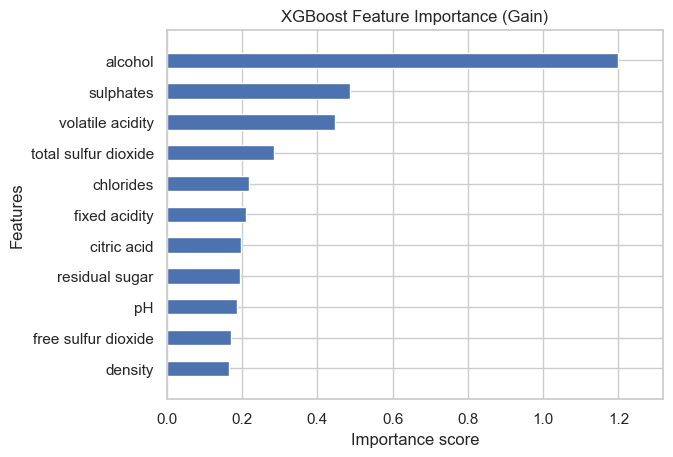

In [222]:
# XGB feature importance plot
xgb.plot_importance(xg_reg, height = 0.5, importance_type = "gain", show_values = False)
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

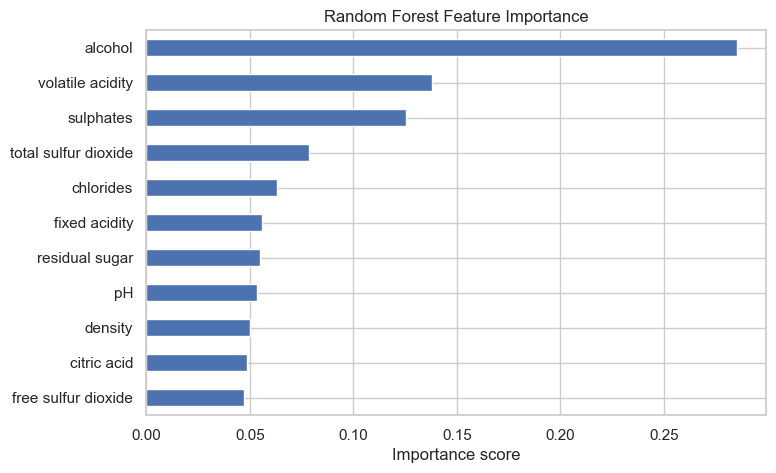

In [223]:
# Random Forest Feature Importance
rf_importances = pd.Series(rf.feature_importances_, index = X.columns)
rf_importances.sort_values().plot(kind = "barh", figsize = (8,5))
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance score")
plt.show()

SHAP

Text(0.5, 1.0, 'Random Forest SHAP Summary')

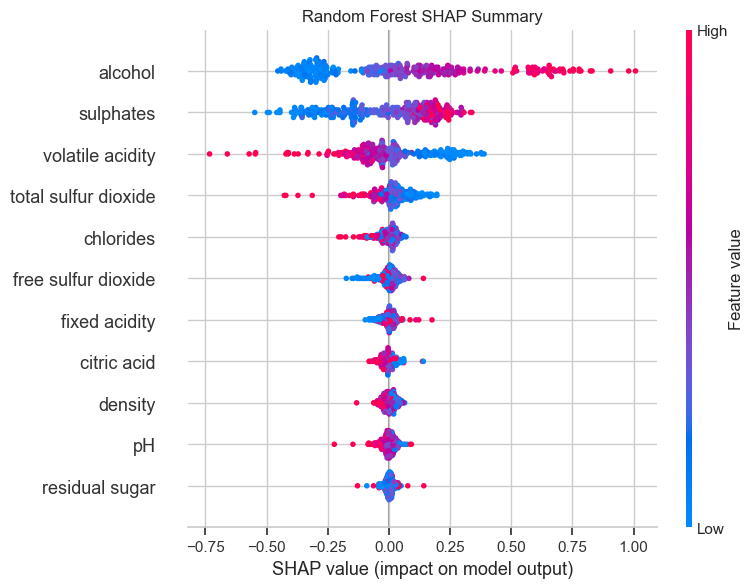

In [224]:
# RF Shap
explain_rf = shap.TreeExplainer(rf)
shap_values_rf = explain_rf.shap_values(X_test)

shap.summary_plot(shap_values_rf, X_test, show=False)
plt.title("Random Forest SHAP Summary")

Text(0.5, 1.0, 'XGBoost SHAP Summary')

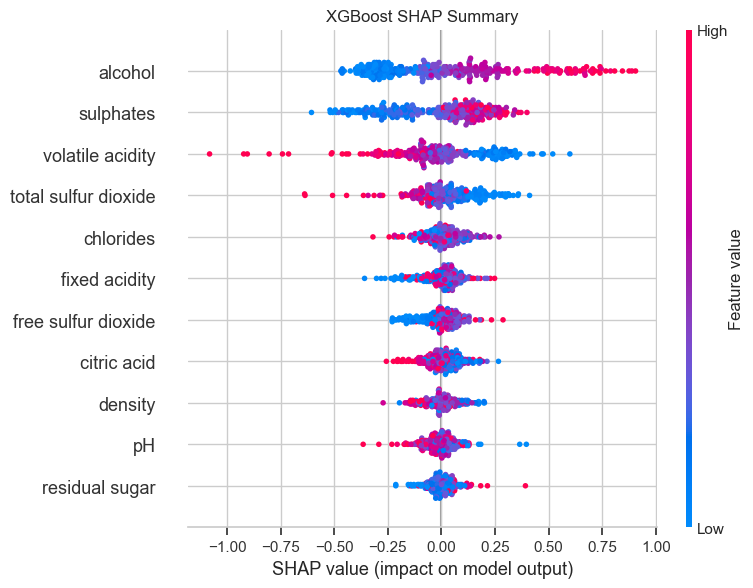

In [225]:
# XGBoost SHAP
explain_xgb = shap.TreeExplainer(xg_reg)
shap_values_xgb = explain_xgb.shap_values(X_test)


shap.summary_plot(shap_values_xgb, X_test, show=False)
plt.title("XGBoost SHAP Summary")

Controlled Distribution Shift - Alcohol

In [226]:
median_alcohol = df["alcohol"].median()

train_shift = df[df["alcohol"] <= median_alcohol]
test_shift = df[df["alcohol"] > median_alcohol]

X_train_shift = train_shift.drop("quality", axis = 1)
y_train_shift = train_shift["quality"]

X_test_shift = test_shift.drop("quality", axis = 1)
y_test_shift = test_shift["quality"]

print("Train Size (low alcohol):", X_train_shift.shape[0])
print("Test Size (high alcohol):", X_test_shift.shape[0])

Train Size (low alcohol): 842
Test Size (high alcohol): 757


Mean Quality (Low Alcohol Train): 5.324
Mean Quality (High Alcohol Test): 5.983


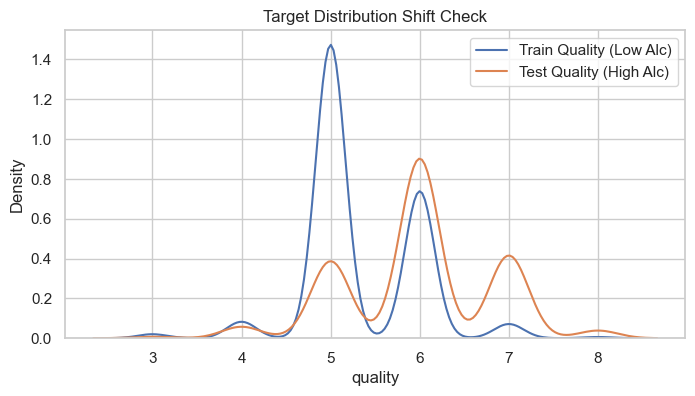

In [241]:
# Diagnostic check for Target Drift
print(f"Mean Quality (Low Alcohol Train): {y_train_shift.mean():.3f}")
print(f"Mean Quality (High Alcohol Test): {y_test_shift.mean():.3f}")

# Compare distributions
plt.figure(figsize=(8,4))
sns.kdeplot(y_train_shift, label="Train Quality (Low Alc)")
sns.kdeplot(y_test_shift, label="Test Quality (High Alc)")
plt.title("Target Distribution Shift Check")
plt.legend()
plt.show()

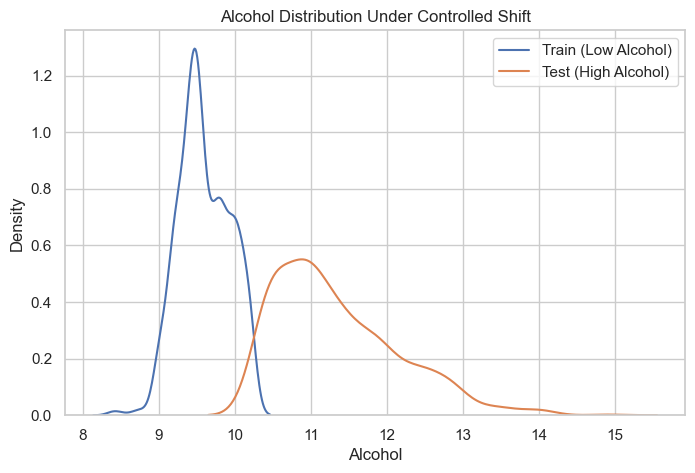

In [227]:
plt.figure(figsize=(8,5))
sns.kdeplot(train_shift["alcohol"], label="Train (Low Alcohol)")
sns.kdeplot(test_shift["alcohol"], label="Test (High Alcohol)")
plt.legend()
plt.title("Alcohol Distribution Under Controlled Shift")
plt.xlabel("Alcohol")
plt.ylabel("Density")
plt.show()

In [228]:
# RF under distribution shift
rf_shift = RandomForestRegressor(n_estimators=500, random_state= 123)
rf_shift.fit(X_train_shift, y_train_shift)

rf_shift_preds = rf_shift.predict(X_test_shift)

rf_shift_rmse = np.sqrt(mean_squared_error(y_test_shift, rf_shift_preds))
rf_shift_mae = mean_absolute_error(y_test_shift, rf_shift_preds)
rf_shift_r2 = r2_score(y_test_shift, rf_shift_preds)

print("Random Forest under Distribution Shift")
print(f"RMSE: {rf_shift_rmse:.3f}\nMAE: {rf_shift_mae:.3f}\nR-squared: {rf_shift_r2:.3f}")

Random Forest under Distribution Shift
RMSE: 0.830
MAE: 0.673
R-squared: 0.002


In [229]:
#XGBoost under dist. shift
xgb_shift = xgb.XGBRegressor(
    n_estimators = 500,
    learning_rate = 0.1,
    max_depth = 5,
    reg_alpha = 0.1,
    reg_lambda = 1,
    random_state = 123,
    objective = "reg:squarederror"
)
xgb_shift.fit(X_train_shift, y_train_shift)

xgb_shift_preds = xgb_shift.predict(X_test_shift)

xgb_shift_rmse = np.sqrt(mean_squared_error(y_test_shift, xgb_shift_preds))
xgb_shift_mae = mean_absolute_error(y_test_shift, xgb_shift_preds)
xgb_shift_r2 = r2_score(y_test_shift, xgb_shift_preds)

print("XGBoost under Distribution Shift")
print(f"RMSE: {xgb_shift_rmse:.3f}\nMAE: {xgb_shift_mae:.3f}\nR-squared: {xgb_shift_r2:.3f} ")

XGBoost under Distribution Shift
RMSE: 0.820
MAE: 0.657
R-squared: 0.026 


In [230]:
# Degradation comparison
rf_original_r2 = r2_score(y_test, rf_preds)
xgb_original_r2 = r2_score(y_test, xgb_predictions)

rf_degradation = rf_original_r2 - rf_shift_r2
xgb_degradation = xgb_original_r2 - xgb_shift_r2

comparison_df = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost"],
    "Original R-squared": [rf_original_r2, xgb_original_r2],
    "Shifted R-squared": [rf_shift_r2, xgb_shift_r2],
    "R-squared Drop": [rf_degradation, xgb_degradation],
})
comparison_df

,Model,Original R-squared,Shifted R-squared,R-squared Drop
0,Random Forest,0.497587,0.001828,0.495759
1,XGBoost,0.450261,0.025794,0.424467


In [243]:
#  Final Summary Table 

summary_df = pd.DataFrame({
    "Model": ["Linear Regression", "Ordinal Regression", "Random Forest", "XGBoost"],
    
    # Test RMSE
    "Test RMSE": [
        np.round(np.sqrt(mean_squared_error(y_test, predict)), 3),
        "-",  # Ordinal Regression is classification
        np.round(np.sqrt(mean_squared_error(y_test, rf_preds)), 3),
        np.round(np.sqrt(mean_squared_error(y_test, xgb_predictions)), 3)
    ],
    
    # Test MAE
    "Test MAE": [
        np.round(mean_absolute_error(y_test, predict), 3),
        np.round(mean_absolute_error(y_test, ord_preds), 3),
        np.round(mean_absolute_error(y_test, rf_preds), 3),
        np.round(mean_absolute_error(y_test, xgb_predictions), 3)
    ],
    
    # Test R²
    "Test R²": [
        np.round(r2_score(y_test, predict), 3),
        "-",  # R² not applicable for ordinal classification
        np.round(r2_score(y_test, rf_preds), 3),
        np.round(r2_score(y_test, xgb_predictions), 3)
    ],
    
    # Cross-Validation 

    "CV R² Mean": [
        np.round(np.mean(lr_cv_scores), 3),
        "-", # ordinal uses MAE
        np.round(np.mean(rf_cv_scores), 3),
        np.round(np.mean(xgb_cv_scores), 3)
    ],
    "CV MAE Mean": [
        "-",
        np.round(-np.mean(ord_cv_scores), 3), # convert negative MAE to positive
        "-",
        "-"
    ],
    
    # R² Drop under high-alcohol distribution shift
    "R² Drop (Shift)": [
        "-",  # Linear Regression shift not tested
        "-",  # Ordinal Regression not applicable
        np.round(rf_degradation, 3),
        np.round(xgb_degradation, 3)
    ]
})

print("Final Model Comparison Table")
summary_df

Final Model Comparison Table


,Model,Test RMSE,Test MAE,Test R²,CV R² Mean,CV MAE Mean,R² Drop (Shift)
0,Linear Regression,0.866,0.704,-0.163,0.346,-,-
1,Ordinal Regression,-,0.659,-,-,0.443,-
2,Random Forest,0.913,0.728,-0.293,0.484,-,0.496
3,XGBoost,0.954,0.746,-0.411,0.456,-,0.424
